<a href="https://colab.research.google.com/github/Userfound404/speech_recognition/blob/main/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**About RAVDESS dataset**

This is the Ryerson Audio-Visual Database of Emotional Speech and Song dataset, and is free to download. This dataset has 7356 files rated by 247 individuals 10 times on emotional validity, intensity, and genuineness. The entire dataset is 24.8GB from 24 actors, but we’ve lowered the sample rate on all the files. In our model, we are taking the emotion (third identifier) in consideration only.

**File naming convention**

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 
04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Download the dateset [here](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio). 

"The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

**Install and Import Libraries**

In [2]:
!pip install opendatasets
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
import pickle
import keras
from keras import layers, Sequential
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import np_utils
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics
import opendatasets as od

**Download Dataset**

In [4]:
od.download("https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: roxpox10
Your Kaggle Key: ··········


100%|██████████| 429M/429M [00:02<00:00, 165MB/s]


In [ ]:
# Emotions in the RAVDESS dataset, different numbers represent different emotion
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

**Extracting features from audio files using librosa**

**The short-time Fourier transform (STFT)**, is a Fourier-related transform used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time. In practice, the procedure for computing STFTs is to divide a longer time signal into shorter segments of equal length and then compute the Fourier transform separately on each shorter segment. This reveals the Fourier spectrum on each shorter segment. One then usually plots the changing spectra as a function of time, known as a spectrogram or waterfall plot

Let result be an empty numpy array. Now, for each feature of the three, if it exists, make a call to the corresponding function from librosa.feature (eg- librosa.feature.mfcc for mfcc), and get the mean value. Call the function hstack() from numpy with result and the feature value, and store this in result. hstack() stacks arrays in sequence horizontally (in a columnar fashion). Then, return the result.

**Mel-frequency cepstral coefficients (MFCCs)**, 
This is the most important step in building a speech recognizer because after converting the speech signal into the frequency domain, we must convert it into the usable form of the feature vector.

**sr** - sample rate, the frequency of the audio

**mel** - mel frequency spectrogram , gives the intensity of the audio at different frequencies
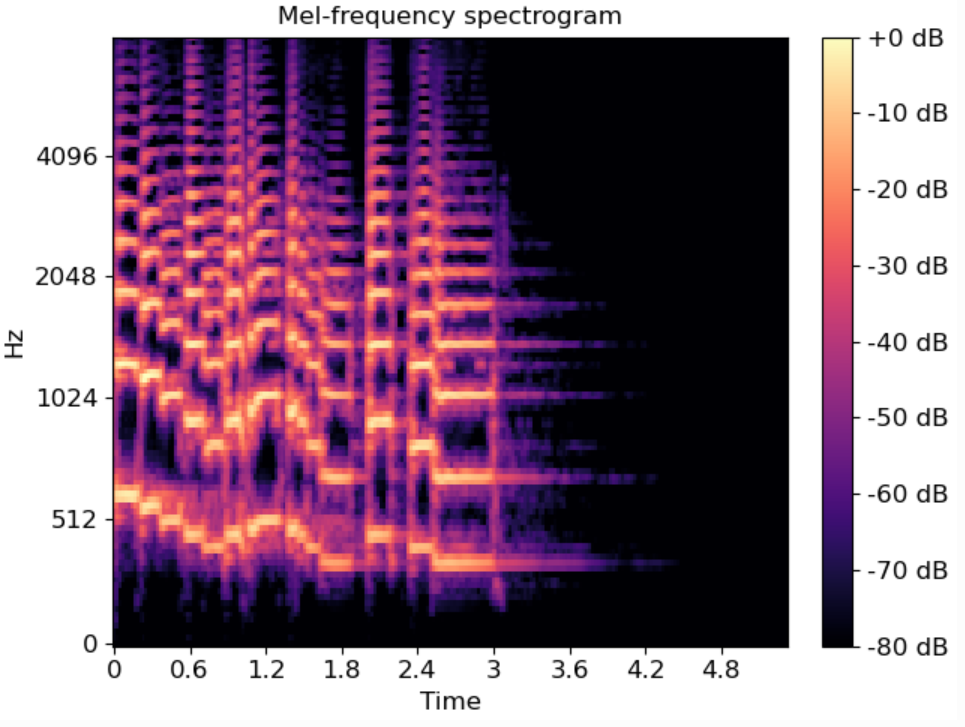

In [ ]:
def extract_feature(data, sr, mfcc, chroma, mel):
    
    """
    extract features from audio files into numpy array
    
    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency
    
    """
    
    if chroma:                          
        stft = np.abs(librosa.stft(data))  
    result = np.array([])
    if mfcc:                          
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:                          
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:                             
        mel = np.mean(librosa.feature.melspectrogram(data, sr=sr).T,axis=0)
        result = np.hstack((result, mel))
        
    return result 

**Data Augmentation**

To increase the genralization of the model we train it with much more real conditions than while recording the dataset

we do that by : 
1.   Noise addition - add random white noises to the audio
2.   Shifting - shift the spectogram in a direction

